In [1]:
# uncomment, modify and run this of you work with Google colab to mount the required data

#import os
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir("/content/drive/MyDrive/DINO_VIT_Tutorial") # insert your path where the downloaded data folder is

# Fruit quality related data sets

## Fayoum banana ripeness ([Mazen et al.](https://link.springer.com/article/10.1007/s13369-018-03695-5))

![](assets/fig_fayoum_examples.png "VExample images from the Fayoum banana dataset")

- 273 images
- 4 ripeness classes

Data set is published on [Google Drive](https://drive.google.com/drive/folders/1nRWBYAHNRqmL4R0SLrs6dbGQFSWGVY8V).


## THE CACS IFW database ([Purdue University](https://engineering.purdue.edu/RVL/Database/IFW/index.html))

![](assets/fig_cascifw_examples.png "Example images from the CASC IFW database")

- 5858 images
- 2 classes: Healthy and damaged

## Other data sets

Feel free to use your own data set in this session or try out one of the following:

- [Fruit Classification (Kaggle)](https://www.kaggle.com/datasets/sshikamaru/fruit-recognition)
- [Fresh and Rotten Fruits (Kaggle)](https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification)

## Pytorch Dataset Class

You can easily create a custom dataset in pytorch:
- Your custom class shoud inherit from the `torch.utils.data.Dataset` class-
- You need to implement the `__len__` and `__getitem__` methods

In [2]:
import os
import warnings
warnings.filterwarnings("ignore") # ignore warnigns

from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt

In [3]:
class FolderDataset(Dataset):
    
    """
    Create a Pytorch dataset based on image folders.
    Classes are expected to be subfolders of the specified directory.
    """
    
    def __init__(self, directory: str, resize=True):
        if resize:
            self.transform = transforms.Compose([
                # step 1: if one dimension is bigger than the other we add padding pixels to the smaller one
                lambda x: transforms.CenterCrop(max(x.shape[-2], x.shape[-1]))(x),
                # step 2: downsample to desired resolution
                transforms.Resize(224)])
        else:
            self.transform = None
        
        self.classes = [folder for folder in os.listdir(directory) if not folder.startswith(".")]
        
        self.all_files = []
        for i, class_ in enumerate(self.classes):
            for file in os.listdir(os.path.join(directory, class_)):
                full_filepath = os.path.join(directory, class_, file)
                if file.endswith(".jpg"):
                    self.all_files.append((full_filepath, i))
        
    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, idx):
        """
        Returns a tuple of an image tensor and a class id)
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label = self.all_files[idx]
        image = torchvision.io.read_image(img_path) / 255
        
        if self.transform:
            image = self.transform(image)

        return image, label

Let's test our class with the Banana dataset.

In [4]:
dataset = FolderDataset("./data/fayoum_banana/images")

In [5]:
dataset.classes

['Green', 'Midripen', 'Yellowish_Green', 'Overripen']

In [6]:
img, label = dataset[0]

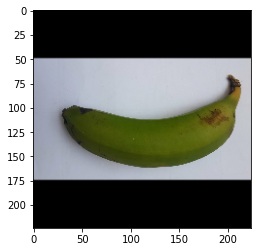

In [7]:
from util import show_tensor_image
show_tensor_image(img)

## Loading pretrained models

Many pretrained models can loaded by just using the torch library. Those models are usually pretrained on the Imagenet data set at a resolution of 224 x 224 pixels.

### CNNs

[Here](https://pytorch.org/vision/stable/models.html) you can find an overview of pretrained CNNs for classification.

Pretrained CNNs from the torchvision library still have the dense classification layer ion the end. So we need to remove it.

In [8]:
resnet = torchvision.models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1]) # removing last layer of the model
resnet.eval(); # inference mode, no gradients are tracked when passing input data

In [9]:
# verify output shape
image = torch.randn(4,3,224,224)
print(f"Input shape: {image.shape}")
output = resnet(image)
print(f"Output shape: {output.shape}")
output = output.squeeze()
print(f"Output shape: {output.shape}")

Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 2048, 1, 1])
Output shape: torch.Size([4, 2048])


### DINO Vision Transformers

You can choose between the following pretrained models.
For more details, see [here](https://github.com/facebookresearch/dino).

| arch          | params | patch size | token dims |
|---------------|--------|------------|------------|
| 'dino_vits16' | 21M    | 16         | 768        |
| 'dino_vits8'  | 21M    | 8          | 384        |
| 'dino_vitb16' | 85M    | 16         | 768        |
| 'dino_vitb8'  | 85M    | 8          | 384        |

Per default, these models return only the CLS token.

In [ ]:
vit = torch.hub.load('facebookresearch/dino:main', "dino_vits16")
vit.eval();

In [11]:
# verify output shape
image = torch.randn(4,3,224,224)
print(f"Input shape: {image.shape}")
output = vit(image)
print(f"Output shape: {output.shape}")

Input shape: torch.Size([4, 3, 224, 224])
Output shape: torch.Size([4, 384])


## Generate latent representations

In [ ]:
loader = DataLoader(dataset, batch_size=32, shuffle=False)
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalize to imagenet mean/std

@torch.no_grad()
def generate_and_save_latents(model, model_name, data_loader, out_dir):
    print(f"Generating embeddings for {model_name}.")
    embeddings = []
    for imgs, label in tqdm(loader):
        imgs_norm = normalize_transform(imgs)
        embeddings.append(model(imgs_norm).detach())
    embeddings = torch.cat(embeddings).squeeze().detach().numpy()
    np.save(os.path.join(out_dir, f"{model_name}.npy"), embeddings)

generate_and_save_latents(resnet, "resnet50", loader, "./data/fayoum_banana/embeddings")
generate_and_save_latents(vit, "dino_vits16", loader, "./data/fayoum_banana/embeddings")


Now let's also save the corresponding class labels.

In [ ]:
labels = torch.cat([label for _, label in tqdm(loader)])
np.save(f"./data/fayoum_banana/embeddings/labels.npy", labels.numpy())

# Task (15 minutes)

- Setup this project in Google Colab or your local Jupyter Environment
- Download the `data` folder as described in `README.md`
- Verify that you can run this notebook without errors
- generate embeddings for the Fayoum Banana dataset using a Neural Network of your choice (e.g. another CNN or another pretrained DINO ViT), and save them as a numpy file to the `./data/fayoum_banana/embeddings` directory

Note: As I am not allowed to share the original data set, embeddings for the apple data set are already generated for several models. You can find them in the `./data/cascifw_apple/embeddings` directory.